In [1]:
## System
import sys
import os
import gzip
from collections import defaultdict

## Pandas
import pandas as pd
import numpy as np
import pyranges as pr

## Plotting 
import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns


In /Users/michaelcormier/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /Users/michaelcormier/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /Users/michaelcormier/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.


In [2]:
scn1a_df = pd.read_csv("../data/SCN1A.ConSplice.50bp.inverse_prop.txt", sep = "\t")

In [3]:
scn1a_df

,#chrom,region_start,region_end,txStart,txEnd,strand,transcript_id,gene_id,gene_symbol,region_size,ConSplice_O/E,ConSplice_Percentile
0,2,165989160,165989209,165989160,166128022,-,ENST00000637988.1,ENSG00000144285.21,SCN1A,50,0.550771,0.234745
1,2,165989210,165989259,165989160,166128022,-,ENST00000637988.1,ENSG00000144285.21,SCN1A,50,-2.263002,0.684787
2,2,165989260,165989309,165989160,166128022,-,ENST00000637988.1,ENSG00000144285.21,SCN1A,50,-6.073674,0.796047
3,2,165989310,165989359,165989160,166128022,-,ENST00000637988.1,ENSG00000144285.21,SCN1A,50,-13.512912,0.875705
4,2,165989360,165989409,165989160,166128022,-,ENST00000637988.1,ENSG00000144285.21,SCN1A,50,-0.943869,0.515556
...,...,...,...,...,...,...,...,...,...,...,...,...
1684,2,166073360,166073409,165989160,166128022,-,ENST00000637988.1,ENSG00000144285.21,SCN1A,50,-116.575082,0.983330
1685,2,166073410,166073459,165989160,166128022,-,ENST00000637988.1,ENSG00000144285.21,SCN1A,50,-29.006690,0.930516
1686,2,166073460,166073509,165989160,166128022,-,ENST00000637988.1,ENSG00000144285.21,SCN1A,50,-15.287627,0.885569
1687,2,166073510,166073559,165989160,166128022,-,ENST00000637988.1,ENSG00000144285.21,SCN1A,50,-21.553985,0.910841


In [4]:
## Rank each region in SCN1A by ConSplice score
scn1a_df["Percentile Rank"] = scn1a_df.ConSplice_Percentile.rank(pct = True)

In [5]:
## Poison exon coordinates
pe1 = {"start":165999051, "end":165999116}
pe2 = {"start":166007230, "end":166007293}
pe3 = {"start":166060640, "end":166060867}

In [6]:
## Max overlaping ConSplice score for each poison exon
pe1_max_ConSplice = scn1a_df.loc[(scn1a_df.region_start < pe1["end"]) & (scn1a_df.region_end > pe1["start"]) ].ConSplice_Percentile.max()
pe2_max_ConSplice = scn1a_df.loc[(scn1a_df.region_start < pe2["end"]) & (scn1a_df.region_end > pe2["start"]) ].ConSplice_Percentile.max()
pe3_max_ConSplice = scn1a_df.loc[(scn1a_df.region_start < pe3["end"]) & (scn1a_df.region_end > pe3["start"]) ].ConSplice_Percentile.max()

In [7]:
## Get min ranking between all 3 poison exons
min_pe_rank = scn1a_df.loc[scn1a_df.ConSplice_Percentile == min(pe1_max_ConSplice,pe2_max_ConSplice,pe3_max_ConSplice)]["Percentile Rank"].values[0]

In [8]:
print("The min SCN1A percentile ranking for poison exons among all ConSplice score in SCN1A is : {}".format(min_pe_rank))

The min SCN1A percentile ranking for poison exons among all ConSplice score in SCN1A is : 0.9224393132030787


In [9]:
## Get CDS exon coordinates and CDS canonical splice site coordinance
scn1a_exons = []

canonical_sites = []

with gzip.open("../data/grch38-canonical-transcript-features-gencode-v1.gtf.gz",  "rt", encoding = "utf-8") as fh:
    header = ["chrom","source","feature","start","end","score","strand","frame","attribute"]
    for line in fh:
        if line[0] == "#":
            continue
        line_dict = dict(zip(header,line.strip().split("\t")))
        line_dict.update({x.strip().replace("\"","").split(" ")[0]:x.strip().replace("\"","").split(" ")[1] for x in line_dict["attribute"].strip().split(";")[:-1]})
        if line_dict["feature"] == "CDS":
            if line_dict["gene_name"] == "SCN1A":
                exon_pos = [line_dict["start"], line_dict["end"]]
                scn1a_exons.append(exon_pos)

                ## Add canoncial acceptor and donor site region
                canonical_sites.append([int(line_dict["start"]) - 2, int(line_dict["start"])])
                canonical_sites.append([int(line_dict["end"]), int(line_dict["end"]) + 2])
                
## Remove first and last canoncial sites, as these are not spliced 
canonical_sites = canonical_sites[1:-1]

In [10]:
## Get Coding and Noncoding ConSplice regions 
scn1a_exons_pr = pr.from_dict({"Chromosome":[2]*len(scn1a_exons), "Start":[x[0] for x in scn1a_exons], "End": [x[1] for x in scn1a_exons]})
scn1a_df = scn1a_df.rename(columns = {"#chrom":"Chromosome","region_start":"Start","region_end":"End"})
scn1a_df["location"] = "All"
scn1a_consplice_pr = pr.PyRanges(scn1a_df)

noncoding_scn1a_consplice_df = scn1a_consplice_pr.overlap(scn1a_exons_pr, invert = True).df
noncoding_scn1a_consplice_df["location"] = "Noncoding"

coding_scn1a_consplice_df = scn1a_consplice_pr.overlap(scn1a_exons_pr, invert = False).df
coding_scn1a_consplice_df["location"] = "Coding"

In [11]:
## Get ConSplice regions that overlap canonical splice sites
canonical_ss_pr = pr.from_dict({"Chromosome":[2]*len(canonical_sites), "Start":[x[0] for x in canonical_sites], "End": [x[1] for x in canonical_sites]})
consplice_canoncial_df = scn1a_consplice_pr.overlap(canonical_ss_pr).df
consplice_canoncial_df["location"] = "Canonical\nSplice Site"

In [12]:
## Combine together
scn1a_location_df = pd.concat([scn1a_df,
                               noncoding_scn1a_consplice_df,
                               coding_scn1a_consplice_df,
                               consplice_canoncial_df])

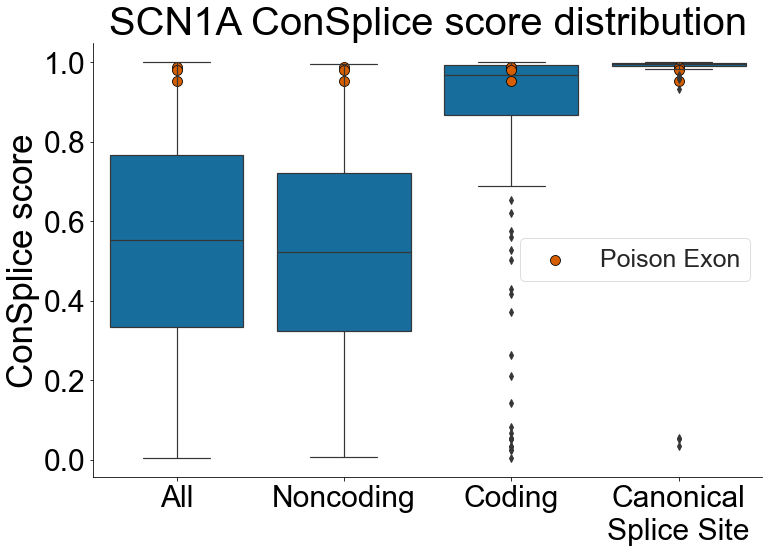

In [13]:
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
plt.rcParams['svg.fonttype'] = 'none'

fig, ax = plt.subplots(figsize = (12,8))
sns.set(font='Arial', style = "white")
sns.set_context("paper", font_scale = 2)
sns.despine()


sns.boxplot(x = "location", y = "ConSplice_Percentile", data = scn1a_location_df, color = sns.color_palette("colorblind")[0] )
sns.scatterplot(x = [0,0,0], y = [pe1_max_ConSplice,pe2_max_ConSplice,pe3_max_ConSplice], s = 100, color = sns.color_palette("colorblind")[3], edgecolor="black")
sns.scatterplot(x = [1,1,1], y = [pe1_max_ConSplice,pe2_max_ConSplice,pe3_max_ConSplice], s = 100, color = sns.color_palette("colorblind")[3], edgecolor="black")
sns.scatterplot(x = [2,2,2], y = [pe1_max_ConSplice,pe2_max_ConSplice,pe3_max_ConSplice], s = 100, color = sns.color_palette("colorblind")[3], edgecolor="black")
sns.scatterplot(x = [3,3,3], y = [pe1_max_ConSplice,pe2_max_ConSplice,pe3_max_ConSplice], s = 100, color = sns.color_palette("colorblind")[3], edgecolor="black", label = "Poison Exon")

ax.set_xlabel("")

ax.set_ylabel("ConSplice score", fontsize = 35)
ax.set_title("SCN1A ConSplice score distribution", fontsize = 40)
ax.tick_params(axis='x', labelsize= 30 )
ax.tick_params(axis='y', labelsize= 30 )

plt.legend(loc = "center right", fontsize = 25)

plt.savefig('../figures/suppl_figure11.svg')

In [14]:
coding_scn1a_consplice_df.ConSplice_Percentile.median()

0.9684079643103696

In [15]:
min([pe1_max_ConSplice,pe2_max_ConSplice,pe3_max_ConSplice])

0.9516398447101676

In [16]:
coding_scn1a_consplice_df.ConSplice_Percentile.median() - min([pe1_max_ConSplice,pe2_max_ConSplice,pe3_max_ConSplice])

0.01676811960020197